# Operations with matrix product operators

## Create the MPO we want

In [1]:
import numpy as np
import sympy as sp
from scipy.special import jn
from scipy.linalg import expm, logm
import qutip as qt
import matplotlib.pyplot as plt

In [2]:
# Pauli Z matrix
sigma_z = np.array([[1.0+0*1j, 0], [0, -1]])

# Identity matrix
I = np.eye(2)

def create_H0_mpo(N, g):
    """
    Creates the MPO for H0 = sum_i g_i sigma_i^z.

    Args:
        N (int): Number of qubits.
        g: Coefficients of g.

    Returns:
        list of np.ndarray: MPO tensors for H0.
    """
    
    mpo = []
    for i in range(N):

        if i == 0:
            # First tensor
            tensor = np.zeros((1, 2, 2, 2), dtype=np.complex128)  # Bond dimension r=2
            tensor[0,0, :, :] = I
            tensor[0,1, :, :] = g * sigma_z
        elif i == N - 1:
            # Last tensor
            tensor = np.zeros((2, 1, 2, 2), dtype=np.complex128)  # Bond dimension r=2
            tensor[0,0, :, :] = g * sigma_z
            tensor[1,0, :, :] = I
        else:
            # Middle tensors
            tensor = np.zeros((2, 2, 2, 2), dtype=np.complex128)  # Bond dimension r=2
            tensor[0,0, :, :] = I
            tensor[0,1, :, :] = g * sigma_z
            tensor[1,1, :, :] = I
        mpo.append(tensor)
        
    return mpo

In [3]:
# Pauli X matrix
sigma_x = np.array([[0, 1.0], [1.0, 0]])

def create_Hc_mpo(N):
    """
    Creates the MPO for Hc = sum_i sigma_i^x.

    Args:
        N (int): Number of qubits.

    Returns:
        list of np.ndarray: MPO tensors for Hc.
    """
    
    mpo = []
    for i in range(N):

        if i == 0:
            # First tensor
            tensor = np.zeros((1, 2, 2, 2), dtype=np.complex128)  # Bond dimension r=2
            tensor[0,0, :, :] = I
            tensor[0,1, :, :] = sigma_x
        elif i == N - 1:
            # Last tensor
            tensor = np.zeros((2, 1, 2, 2), dtype=np.complex128)  # Bond dimension r=2
            tensor[0,0, :, :] = sigma_x
            tensor[1,0, :, :] = I
        else:
            # Middle tensors
            tensor = np.zeros((2, 2, 2, 2), dtype=np.complex128)  # Bond dimension r=2
            tensor[0,0, :, :] = I
            tensor[0,1, :, :] = sigma_x
            tensor[1,1, :, :] = I
        mpo.append(tensor)
        
    return mpo

In [4]:
def create_I_mpo(N):

    mpo = []
    for i in range(N):
        tensor = np.zeros((1, 1, 2, 2), dtype=np.complex128)  # Bond dimension r=1
        tensor[0,0, :, :] = I
        mpo.append(tensor)

    return mpo
        

## Define the functions to operate (sum, product)

In [5]:
def add(mpo1,mpo2):

    assert len(mpo1) == len(mpo2)

    new_mpo = []

    ## First we add the empty first boundary to the new list of core tensors
    new_mpo.append(np.zeros((1,mpo1[0].shape[1]+mpo2[0].shape[1],2,2), dtype=np.complex128))

    ## Add the rectangular tensors in the center
    if len(mpo1)>2:
        for i in range(1,len(mpo1)-1):
            new_mpo.append(np.zeros((mpo1[i].shape[0]+mpo2[i].shape[0],mpo1[i].shape[1]+mpo2[i].shape[1],2,2), dtype=np.complex128))

    ## Add the last ending boundary of the list of tensors
    new_mpo.append(np.zeros((mpo1[len(mpo1)-1].shape[0]+mpo2[len(mpo2)-1].shape[0],1,2,2), dtype=np.complex128))

    ## Compute the tensors for the boundaries
    for j in range(mpo1[0].shape[1]):
        new_mpo[0][0,j,:,:] = mpo1[0][0,j,:,:]
    for k in range(mpo2[0].shape[1]):
        new_mpo[0][0,mpo1[0].shape[1]+k,:,:] = mpo2[0][0,k,:,:]

    for j in range(mpo1[len(mpo1)-1].shape[0]):
        new_mpo[len(mpo1)-1][j,0,:,:] = mpo1[len(mpo1)-1][j,0,:,:]
    for k in range(mpo2[len(mpo2)-1].shape[0]):
        new_mpo[len(mpo2)-1][mpo1[len(mpo1)-1].shape[0]+k,0,:,:] = mpo2[len(mpo2)-1][k,0,:,:]

    ## Now the tensors in the middle
    if len(mpo1)>2:
        for i in range(1,len(mpo1)-1):
            for j in range(mpo1[i].shape[0]):
                for k in range(mpo1[i].shape[1]):
                    new_mpo[i][j,k,:,:] = mpo1[i][j,k,:,:]
    
            for j in range(mpo2[i].shape[0]):
                    for k in range(mpo2[i].shape[1]):
                        new_mpo[i][mpo1[i].shape[0]+j,mpo1[i].shape[1]+k,:,:] = mpo2[i][j,k,:,:]
    
    return new_mpo

In [6]:
def prod_scalar(mpo, c):
    new_mpo = [np.copy(tensor) for tensor in mpo]  # Make a deep copy
    for i in range(new_mpo[0].shape[0]):
        for j in range(new_mpo[0].shape[1]):
            for k in range(new_mpo[0].shape[2]):
                for l in range(new_mpo[0].shape[3]):
                    new_mpo[0][i, j, k, l] *= c
    return new_mpo

In [7]:
def prod(mpo1,mpo2):
    
    assert len(mpo1) == len(mpo2)

    new_mpo = []

    ## First we add the empty first boundary to the new list of core tensors
    new_mpo.append(np.zeros((1,mpo1[0].shape[1]*mpo2[0].shape[1],2,2), dtype=np.complex128))

    ## Add the rectangular tensors in the center
    if len(mpo1)>2:
        for i in range(1,len(mpo1)-1):
            new_mpo.append(np.zeros((mpo1[i].shape[0]*mpo2[i].shape[0],mpo1[i].shape[1]*mpo2[i].shape[1],2,2), dtype=np.complex128))

    ## Add the last ending boundary of the list of tensors
    new_mpo.append(np.zeros((mpo1[len(mpo1)-1].shape[0]*mpo2[len(mpo2)-1].shape[0],1,2,2), dtype=np.complex128))

    ## Compute the tensors for the boundaries
    for j in range(mpo1[0].shape[1]):
        for k in range(mpo2[0].shape[1]):
            new_mpo[0][0,k+j*(mpo2[0].shape[1]),:,:] = np.outer(mpo1[0][0,j,:,0],mpo2[0][0,k,0,:])+np.outer(mpo1[0][0,j,:,1],mpo2[0][0,k,1,:])

    for j in range(mpo1[len(mpo1)-1].shape[0]):
        for k in range(mpo2[len(mpo2)-1].shape[0]):
            new_mpo[len(mpo1)-1][k+j*(mpo2[len(mpo2)-1].shape[0]),0,:,:] = np.outer(mpo1[len(mpo1)-1][j,0,:,0],mpo2[len(mpo2)-1][k,0,0,:])+np.outer(mpo1[len(mpo1)-1][j,0,:,1],mpo2[len(mpo2)-1][k,0,1,:])


    ## Now we compute the values of the intermediate tensor cores
    if len(mpo1)>2:
        ## For each core tensor
        for i in range(1,len(mpo1)-1):
            ## Take each element of the first tensor
            for j in range(mpo1[i].shape[0]):
                for k in range(mpo1[i].shape[1]):

                    ## Compute with all the elements of the equivalent tensor in second mpo
                    for s in range(mpo2[i].shape[0]):
                        for t in range(mpo2[i].shape[1]):
                            new_mpo[i][s+j*(mpo2[i].shape[1]),t+k*(mpo2[i].shape[1]),:,:] = np.outer(mpo1[i][j,k,:,0],mpo2[i][s,t,0,:])+np.outer(mpo1[i][j,k,:,1],mpo2[i][s,t,1,:])

    return new_mpo

## From MPO to full matrix

In [8]:
def contract(mpo):
    ## Create list for recursive multiplication of matrices, step by step
    mpo_contracted = []
    ## We define the first one as it's fixed
    mpo_contracted.append(mpo[0])
    for n in range(len(mpo)-1):
        ## For the first compression starting left to right we set an empty compressed tensor
        mpo_contracted.append(np.zeros((mpo[n].shape[0],mpo[n+1].shape[1],2**(n+2),2**(n+2)), dtype=np.complex128))
            
        for i in range(mpo[n+1].shape[1]):
            ## Now go over every element and take matrix multiplication with kronecker product
            mpo_comp = 0
            for j in range(mpo[n].shape[1]):
                mpo_comp += np.kron((mpo_contracted[n])[0,j,:,:],(mpo[n+1])[j,i,:,:])

                ## Add in the list to continue with the next compression
                (mpo_contracted[n+1])[0,i] = mpo_comp
                
    return mpo_contracted[len(mpo)-1][0][0]

In [9]:
def commutator(mpo1,mpo2):
    return add(prod(mpo1,mpo2),prod_scalar(prod(mpo2,mpo1),-1))

In [10]:
def commute(M1,M2):
    return (M1 @ M2) - (M2 @ M1) 

## Bond reduction of the tensors

In [11]:
def reduce(mpo, bond_dimension):

    new_mpo = []
    return new_mpo

## Magnus and Chebyshev approximations for evolution

In [12]:
def Magnus_mpo(mpo_H0,mpo_Hc,u,T):

    """
   First step to solve the time-dependent Schrödinger equation via Magnus expansion.

    Parameters:
    - mpo_H0: numpy array, static Hamiltonian as mpo
    - mpo_Hc: numpy array, control Hamiltonian as mpo
    - u: function u(t) defining time dependence
    - T: float, total evolution time

    Returns:
    - M: Magnus series
    """

    ## Magnus series (order 2)
    t1, t2, t3 = sp.symbols('t1 t2 t3')

    a = -1j*sp.integrate(1,(t1,0,T))
    b = -1j*sp.integrate(u(t1), (t1, 0, T)) 

    M1 = add(prod_scalar(mpo_H0,a),prod_scalar(mpo_Hc,b))

    c = -1/2 * sp.integrate(sp.integrate(u(t2)-u(t1),(t2,0,t1)),(t1,0,T))

    M2 = prod_scalar(commutator(mpo_H0,mpo_Hc),c)

    d = 1j/6 * sp.integrate(sp.integrate(sp.integrate(u(t3)-2*u(t2)+u(t1),(t3,0,t2)),(t2,0,t1)),(t1,0,T))
    e = 1j/6 * sp.integrate(sp.integrate(sp.integrate(2*u(t1)*u(t3)-u(t1)*u(t2)-u(t2)*u(t3),(t3,0,t2)),(t2,0,t1)),(t1,0,T))

    M3 = add(prod_scalar(commutator(mpo_H0,commutator(mpo_H0,mpo_Hc)),d),prod_scalar(commutator(commutator(mpo_Hc,mpo_H0),mpo_Hc),e))
    
    M = add(M1,M2)

    return M

In [13]:
def Magnus(H0,Hc,u,T):

    """
   First step to solve the time-dependent Schrödinger equation via Magnus expansion.

    Parameters:
    - mpo_H0: numpy array, static Hamiltonian as mpo
    - mpo_Hc: numpy array, control Hamiltonian as mpo
    - u: function u(t) defining time dependence
    - T: float, total evolution time

    Returns:
    - M: Magnus series
    """
    def commute(M1,M2):
        return (M1 @ M2) - (M2 @ M1)

    ## Magnus series (order 2)
    t1, t2, t3 = sp.symbols('t1 t2 t3')

    a = -1j*sp.integrate(1,(t1,0,T))
    b = -1j*sp.integrate(u(t1), (t1, 0, T)) 

    M1 = (a*H0) + (b*Hc)

    c = -1/2 * sp.integrate(sp.integrate(u(t2)-u(t1),(t2,0,t1)),(t1,0,T))

    M2 = c*commute(H0,Hc)

    d = 1j/6 * sp.integrate(sp.integrate(sp.integrate(u(t3)-2*u(t2)+u(t1),(t3,0,t2)),(t2,0,t1)),(t1,0,T))
    e = 1j/6 * sp.integrate(sp.integrate(sp.integrate(2*u(t1)*u(t3)-u(t1)*u(t2)-u(t2)*u(t3),(t3,0,t2)),(t2,0,t1)),(t1,0,T))

    M3 = d*(commute(H0,commute(H0,Hc))) + e*(commute(commute(Hc,H0),Hc))
    
    M = M1 + M2

    return M

In [14]:
def Chebyshev_mpo(mpo,N):
    """ 
    Approximation of exponentiation of Magnus series to find the solution to the Schrödinger equation
    """

    ##Bessel function constants
    
    a = jn(0,1)+2*jn(2,1)
    b = 2*jn(1,1)
    c = 4*jn(2,1)

    C1 = prod_scalar(create_I_mpo(N),a)
    C2 = prod_scalar(mpo,b)
    C3 = prod_scalar(prod(mpo,mpo),c)

    C = add(C1,C2)

    
    return C

In [15]:
def Chebyshev(M,N):
    """ 
    Approximation of exponentiation of Magnus series to find the solution to the Schrödinger equation
    """

    ##Bessel function constants
    
    a = jn(0,1)+2*jn(2,1)
    b = 2*jn(1,1)
    c = 4*jn(2,1)

    C1 = a*np.eye(M.shape[0])
    C2 = b*M
    C3 = (c*M) @ M

    C = C1+C2

    
    return C

## Exact evolution

In [16]:
def get_unitary(H0, Hc, u, T, timesteps=1000):
    """
    Solves the time-dependent Schrödinger equation and returns the unitary evolution matrix.

    Parameters:
    - H0: numpy array, static Hamiltonian
    - Hc: numpy array, control Hamiltonian
    - u: function u(t) defining time dependence
    - T: float, total evolution time
    - timesteps: int, number of time steps for integration

    Returns:
    - U_T: numpy array, final unitary matrix at time T
    """

    # Convert matrices to Qobj
    H0_q = qt.Qobj(H0)
    Hc_q = qt.Qobj(Hc)

    # Time-dependent Hamiltonian
    H = [H0_q, [Hc_q, u]]

    # Initial state (identity operator for unitary evolution)
    identity = qt.qeye(H0.shape[0])
    psi0 = identity

    # Time array
    tlist = np.linspace(0, T, timesteps)

    # Solve Schrödinger equation
    result = qt.sesolve(H, psi0, tlist)

    # Extract final unitary matrix
    U_T = result.states[-1].full()

    return U_T

In [17]:
def log(U):
    
    eigvals, eigvecs = np.linalg.eig(U)

    log_eigvals = np.diag(np.log(eigvals))

    # Reconstruct the logarithm of the matrix
    log_U = eigvecs @ log_eigvals @ np.linalg.inv(eigvecs)
    
    return log_U

In [18]:
def err_fidelity(U,V):

    ## Computes the fidelity error: 1-fidelity

    d = U.shape[0]  # Dimension of the unitary matrices
    fidelity = (np.abs(np.trace(np.conj(U.T) @ V)) / d) ** 2
    return 1 - fidelity

In [19]:
def full_compare(N,g,T):

    ## Compare (error) the exact solution to the MPO solution with Magnus and M+C
    
    mpo1 = prod_scalar(create_H0_mpo(N,g),1/np.linalg.norm(contract(create_H0_mpo(N,g))))
    mpo2 = prod_scalar(create_Hc_mpo(N),1/np.linalg.norm(contract(create_Hc_mpo(N))))
    H0 = contract(mpo1)
    Hc = contract(mpo2)

    ## Define the control function
    def u(t):
        return 1-t+t**2

    U_exact = get_unitary(H0,Hc,u, T)
    Mag = Magnus_mpo(mpo1,mpo2,u, T)
    U_computed = Chebyshev_mpo(Mag,N)

    Err1 = err_fidelity(U_exact,expm(contract(Mag)))
    Err2 = err_fidelity(U_exact,contract(U_computed))
    Err3 = np.linalg.norm(U_exact-expm(contract(Mag)))
    Err4 = np.linalg.norm(U_exact-contract(U_computed))

    return Err1, Err2, Err3, Err4

In [20]:
def compare(N,g,T):

    ## Compare (error) the exact solution to the MPO solution with Magnus and M+C
    
    mpo1 = prod_scalar(create_H0_mpo(N,g),1/np.linalg.norm(contract(create_H0_mpo(N,g))))
    mpo2 = prod_scalar(create_Hc_mpo(N),1/np.linalg.norm(contract(create_Hc_mpo(N))))
    H0 = contract(mpo1)
    Hc = contract(mpo2)

    ## Define the control function
    def u(t):
        return 1-t+t**2

    U_exact = get_unitary(H0,Hc,u, T)
    Mag = Magnus_mpo(mpo1,mpo2,u, T)
    U_computed = Chebyshev_mpo(Mag,N)

    Err = err_fidelity(U_exact,contract(U_computed))

    return Err

## Example trial

## Plots

### Compare MPO evolution to exact

In [21]:
N1 = 7
g1 = 1
T1 = 0.5

errs = []

for i in range(2,N1+1):
    errs.append(compare(i,g1,T1))

C:\Users\llore\anaconda3\Lib\site-packages\qutip\solver\integrator\scipy_integrator.py:80: SparseEfficiencyWarning: Constructing a DIA matrix with 128 diagonals is inefficient
  state0 = _data.column_stack(state0)
C:\Users\llore\anaconda3\Lib\site-packages\qutip\solver\integrator\scipy_integrator.py:80: SparseEfficiencyWarning: Constructing a DIA matrix with 256 diagonals is inefficient
  state0 = _data.column_stack(state0)


Text(0, 0.5, 'Infidelity between exact and MPO')

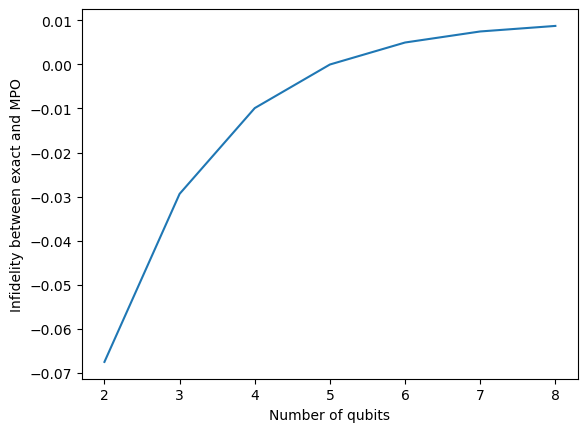

In [22]:
plt.plot(range(2,N1+1),errs)
plt.xlabel('Number of qubits')
plt.ylabel('Infidelity between exact and MPO')

### Full comparison

In [29]:
err_magnus = []
err_cheby = []
err_magnus1 = []
err_cheby1 = []

for i in range(2,N1+1):
    err1, err2, err3, err4 = full_compare(i,g1,T1)

    err_magnus.append(err1)
    err_cheby.append(err2)
    err_magnus1.append(err3)
    err_cheby1.append(err4)

C:\Users\llore\anaconda3\Lib\site-packages\qutip\solver\integrator\scipy_integrator.py:80: SparseEfficiencyWarning: Constructing a DIA matrix with 128 diagonals is inefficient
  state0 = _data.column_stack(state0)
C:\Users\llore\anaconda3\Lib\site-packages\qutip\solver\integrator\scipy_integrator.py:80: SparseEfficiencyWarning: Constructing a DIA matrix with 256 diagonals is inefficient
  state0 = _data.column_stack(state0)


Text(0, 0.5, 'Infidelity of just Magnus')

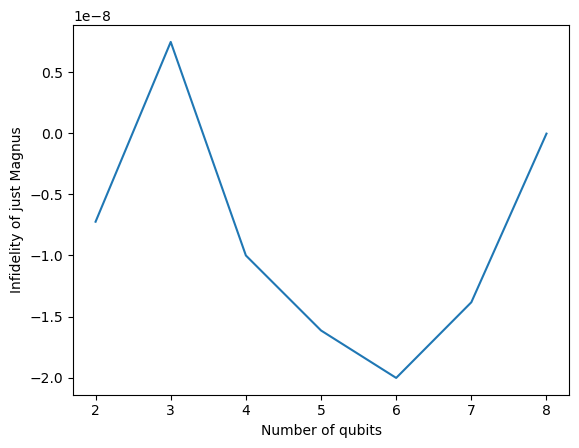

In [30]:
plt.plot(range(2,N1+1),err_magnus)
plt.xlabel('Number of qubits')
plt.ylabel('Infidelity of just Magnus')

Text(0, 0.5, 'Infidelity of Magnus and Chebyshev')

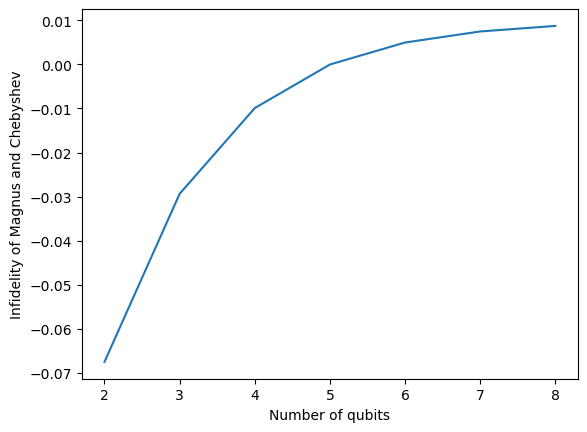

In [31]:
plt.plot(range(2,N1+1),err_cheby)
plt.xlabel('Number of qubits')
plt.ylabel('Infidelity of Magnus and Chebyshev')

Text(0, 0.5, 'Norm error of Magnus')

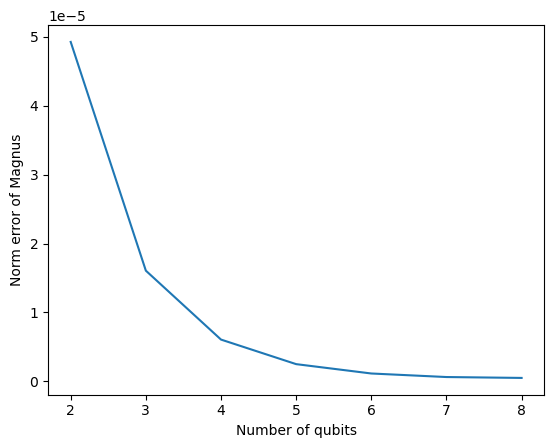

In [32]:
plt.plot(range(2,N1+1),err_magnus1)
plt.xlabel('Number of qubits')
plt.ylabel("Norm error of Magnus")

Text(0, 0.5, 'Norm error Magnus and Chebyshev')

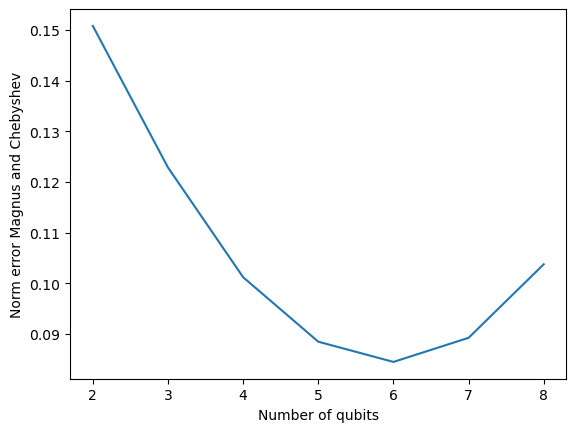

In [33]:
plt.plot(range(2,N1+1),err_cheby2)
plt.xlabel('Number of qubits')
plt.ylabel('Norm error Magnus and Chebyshev')